## Introducción

En esta notebook voy a trabajar sobre un modelo de clasificación de transacciones fraudulentas mediante un modelo de clasificación binaria. El dataset lo obtuve de [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv). Está conformado por variables numéricas que son el resultado de una transformación PCA (V1 a V28), a excepción de Time y Amount. La variable *Time* contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La variable *Amount*es el monto de la transacción. La variable *Class* es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

El proyecto comprende una etapa exploratoria de datos (EDA), el entrenamiento de los modelos y la obtención de las métricas y un último capítulo de obtención de reglas para facilitar la *interpretabilidad del modelo*.



In [1]:
# Activo las librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score #cross validation
from sklearn.linear_model import LogisticRegression #Ligistic Regression
from sklearn.tree import DecisionTreeClassifier #Decision Tree
import xgboost as xgb # xgboost
import lightgbm as lgb # LigthGBM
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.compose import ColumnTransformer #Aplicador preprocesamiento a columnas
from sklearn.metrics import accuracy_score #metricas de error
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy import stats #importo stats para implementar el ks
from plotnine import * #Uso grammar graphics para visualizaciones
import os
import re

# Configuro para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [2]:
#Listo todo los archivos en la carpeta "data" y cargo el archivo

list_files = os.listdir("data")
list_files
data = pd.read_csv(os.path.join("data",list_files[0]))

In [3]:
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


## Análisis exploratorio

In [4]:
# vemos la existencia de valores nulos

data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

   Class      TX   prop
0      0  284315  99.83
1      1     492   0.17


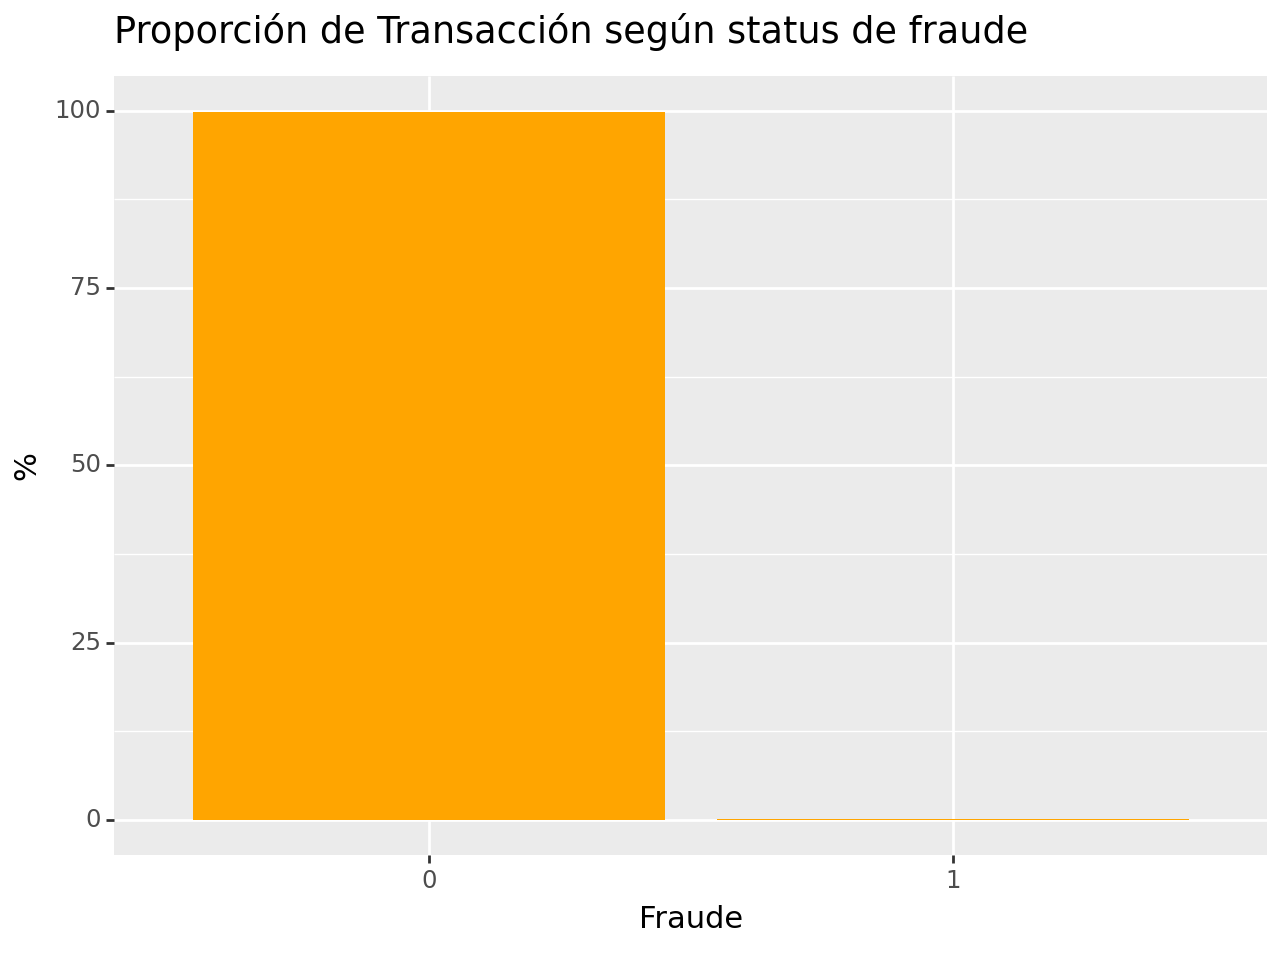

<Figure Size: (640 x 480)>

In [5]:
#Analizamos la distribución de las clases

fraud_prop = data.groupby('Class')['Class']\
.count()\
.reset_index(name="TX")\
.assign(prop= lambda x: round(x['TX']*100/x['TX'].sum(),2))

print(fraud_prop)

(ggplot(fraud_prop,aes(x= 'factor(Class)', y= 'prop'))+
geom_bar(stat= 'identity', fill= 'Orange')+
labs(title= 'Proporción de Transacción según status de fraude', x= "Fraude", y= "%"))



C:\Users\NaranjaX\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


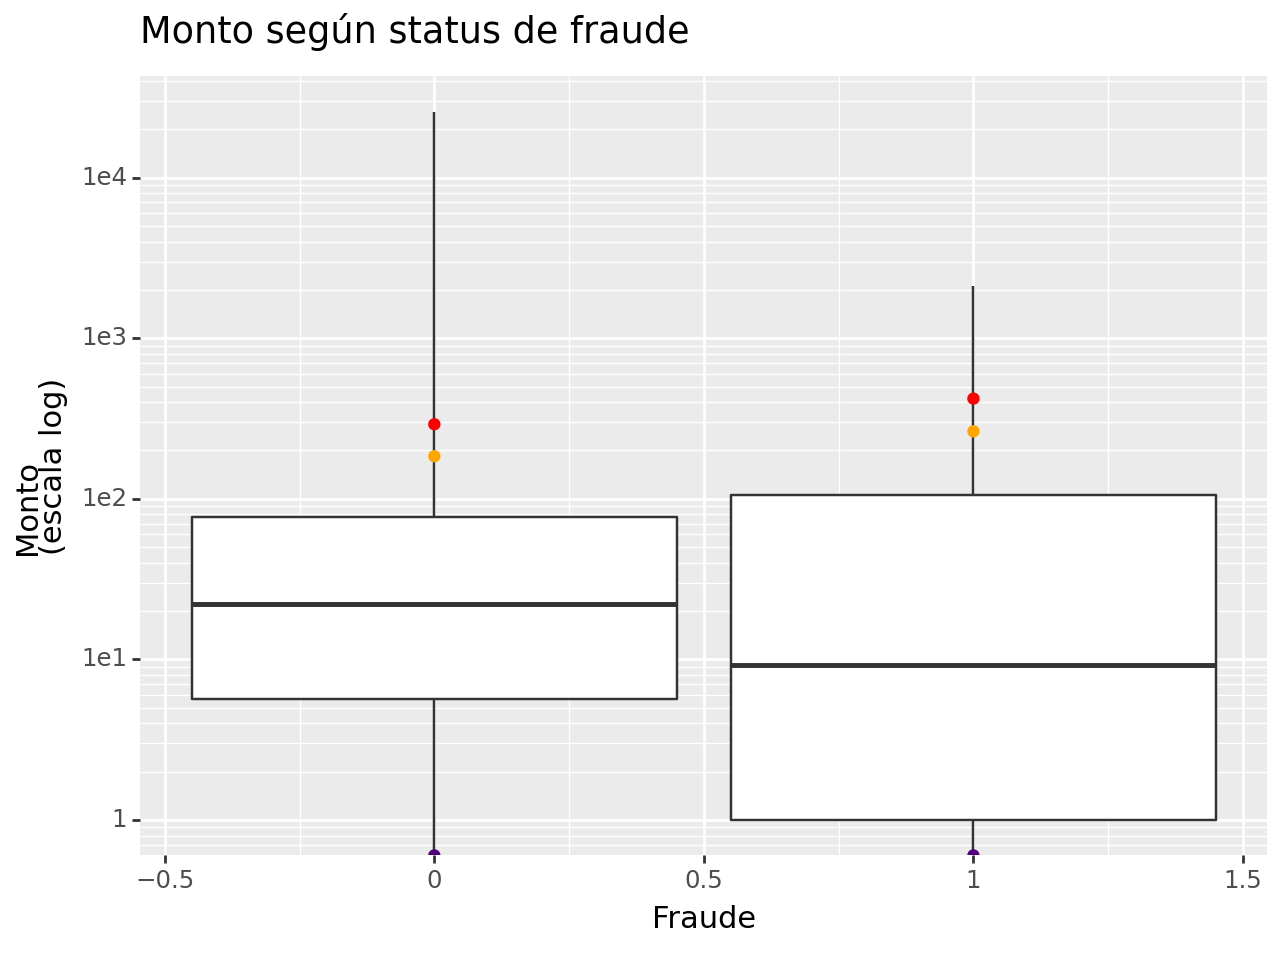

<Figure Size: (640 x 480)>

In [6]:
#Analizamos el amount según el tipo de transaccion (target)

data['Amount'] = data['Amount'].astype(float)

fraud_amount = data.groupby(['Class'], as_index= False)\
.agg(
y0 = ('Amount',lambda x: x.min(skipna= True)),
y25 = ('Amount',lambda x: x.quantile(0.25)),
y50 = ('Amount',lambda x: x.quantile(0.50)),
y75 = ('Amount',lambda x: x.quantile(0.75)),
y100 = ('Amount',lambda x: x.max(skipna= True)),
atipic_sup_1_5 = ('Amount', lambda x: x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))),
atipic_sup_3 = ('Amount', lambda x: x.quantile(0.75) + 3 * (x.quantile(0.75) - x.quantile(0.25))),
mean = ('Amount',lambda x: x.min(skipna= True))
    
)


(ggplot(fraud_amount,aes(x= 'Class'))+ \
        geom_boxplot(
        aes(ymin = 'y0', lower = 'y25', middle = 'y50', upper = 'y75', ymax = 'y100'),
        stat = "identity")+ \
        geom_point(aes(y= 'mean'),color= "#50007b",fill= "#50007b",)+ \
        geom_point(aes(y= 'atipic_sup_1_5'), colour= "orange")+\
        geom_point(aes(y= 'atipic_sup_3'), colour= "red")+\
        scale_y_log10()+\
        labs(x= "Fraude", y= "Monto\n(escala log)",
        title= "Monto según status de fraude"))



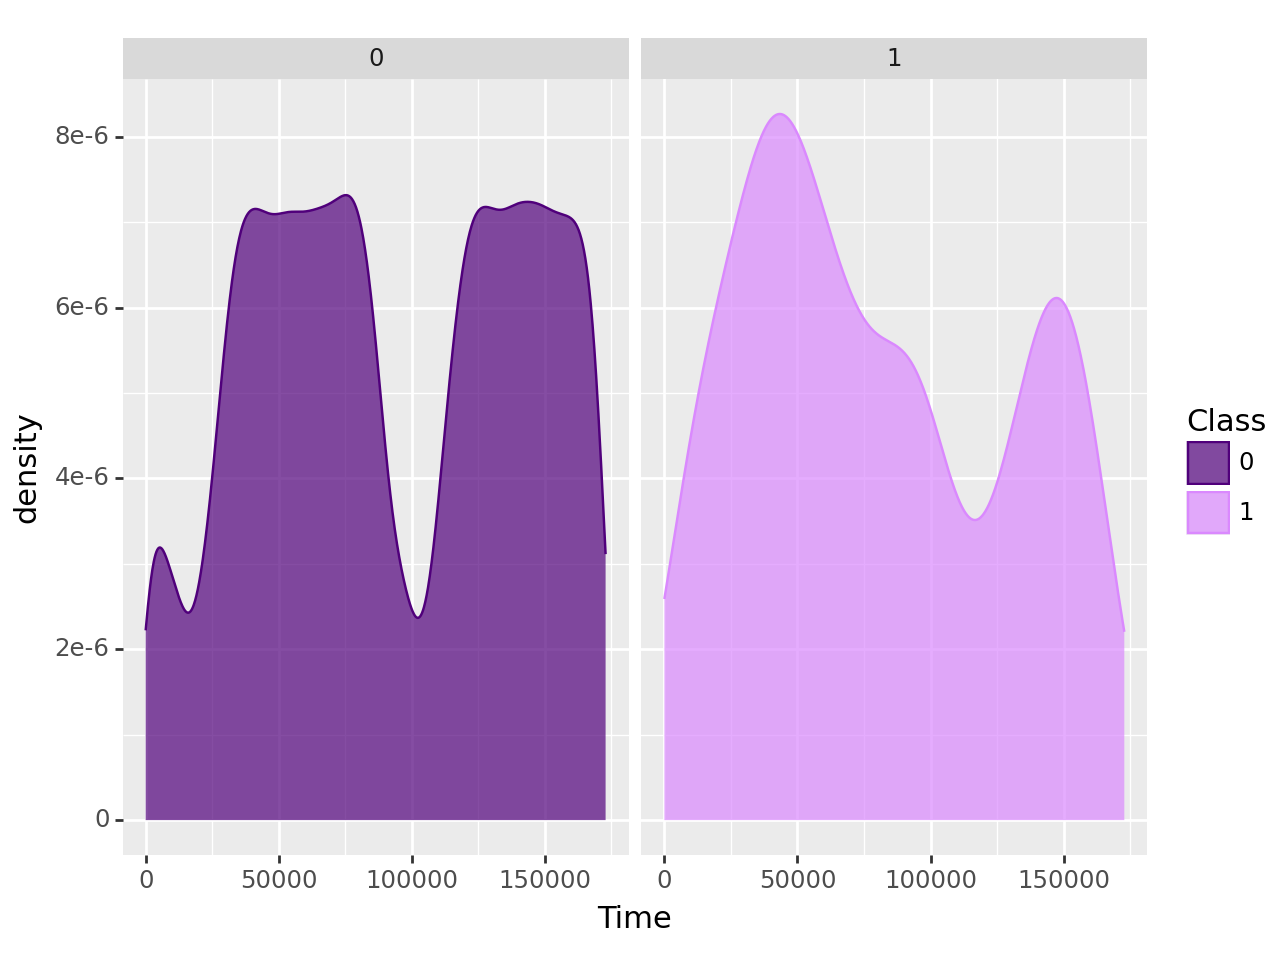

<Figure Size: (640 x 480)>

In [7]:
#Analizamos la variable Timne

distr_time = data.groupby(['Class','Time'])\
.size()\
.reset_index(name='n')\
.assign(prop = lambda x: round(x['n']*100/ x.groupby(['Class'])['n'].transform('sum')))

# distr_time
#Visualizo los datos


#Cambio el tipo de Class
distr_time['Class'] = distr_time['Class'].astype('category')

pal = ["#50007B","#DA89FE"]

(ggplot(distr_time, aes('Time', color ='Class',fill= 'Class')) +
 geom_density(alpha=0.7)+
facet_wrap('Class')+
scale_fill_manual(values= pal)+
scale_color_manual(values= pal))


In [8]:
#Analizo la correlación entre las variables numericas

#defino las variables numericas
numerical= data.select_dtypes(include=['int64','int32','float64']).columns

#Creo el dataset especifico para la matriz
data_corr = data.loc[:,numerical].drop('Class',axis= 1)


#Creo la matriz de correlación
corr = data_corr.corr()\
.round(1)
corr


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Time,1.0,0.1,-0.0,-0.4,-0.1,0.2,-0.1,0.1,-0.0,-0.0,0.0,-0.2,0.1,-0.1,-0.1,-0.2,0.0,-0.1,0.1,0.0,-0.1,0.0,0.1,0.1,-0.0,-0.2,-0.0,-0.0,-0.0,-0.0
V1,0.1,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.2
V2,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.5
V3,-0.4,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.2
V4,-0.1,-0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.1
V5,0.2,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.4
V6,-0.1,-0.0,0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.2
V7,0.1,-0.0,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.4
V8,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.1
V9,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0


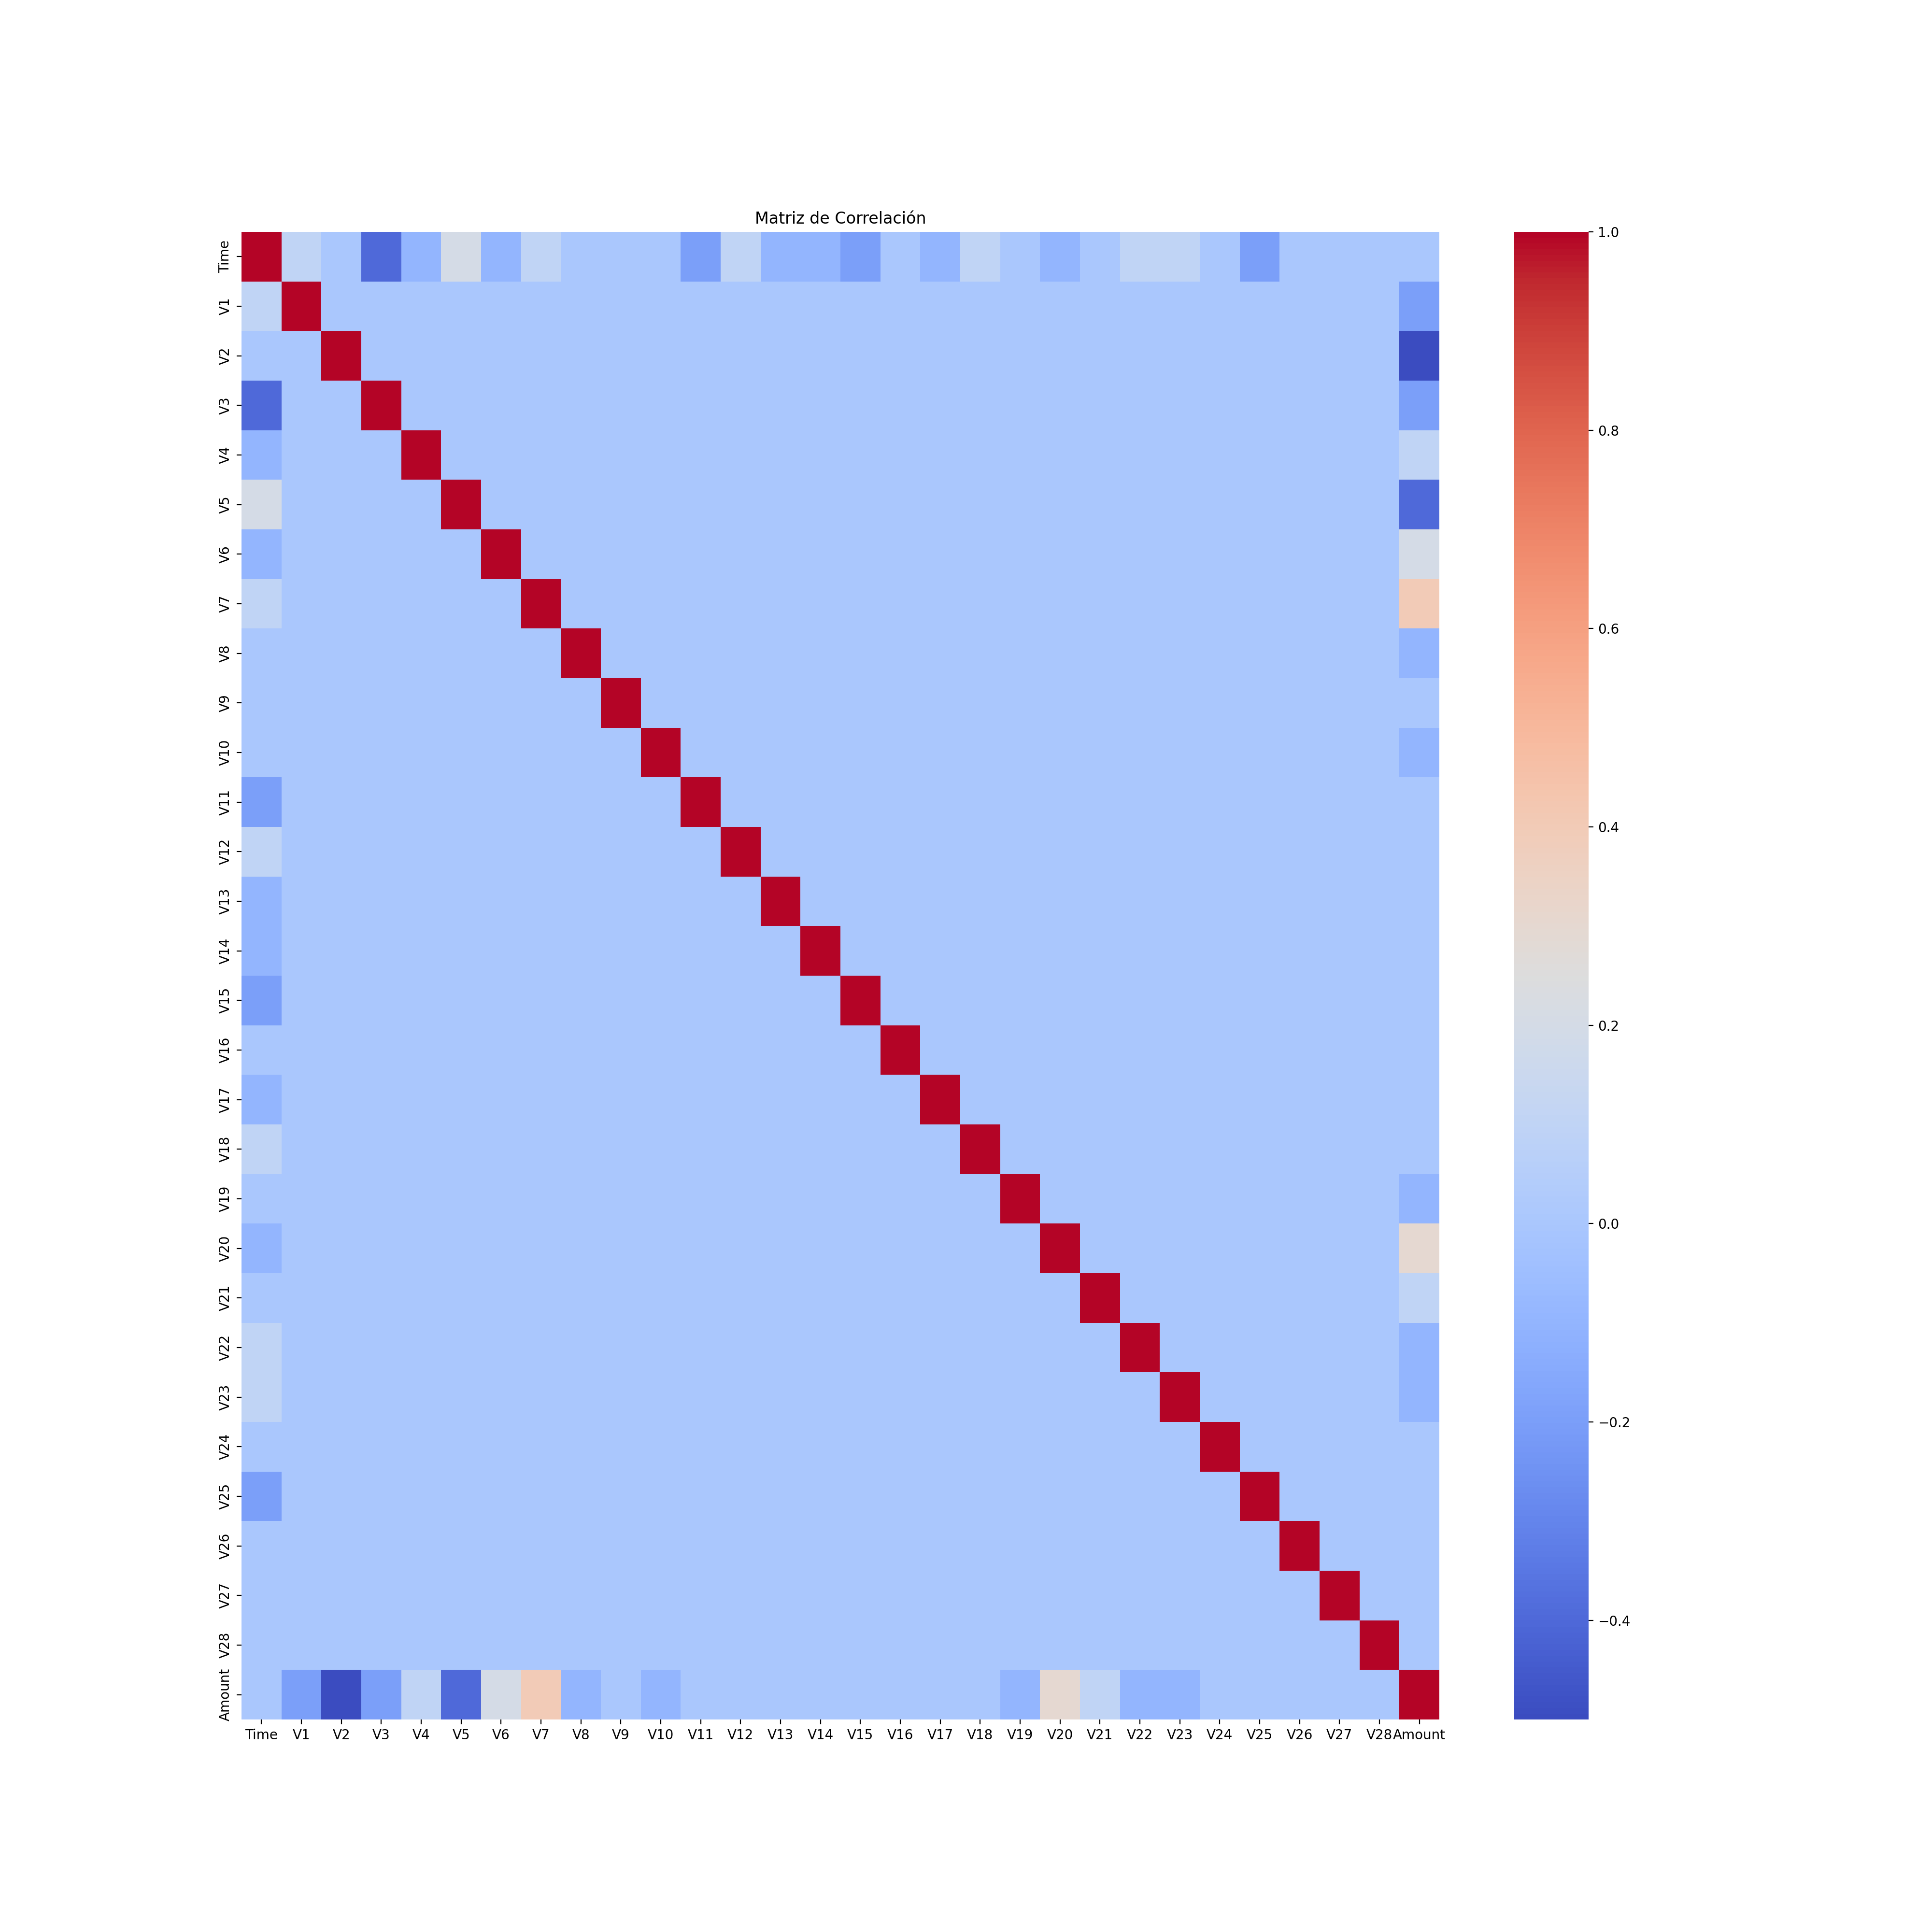

In [9]:
#Visualizo la matriz

plt.figure(figsize=(20, 20))
sns.heatmap(corr , annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

### Comentarios del Análisis Exploratorio

 - Como primer punto debemos destacar el fuerte desbalance que tienen los datos, sólo el **0,17% (n= 492)** de 284.807 transacciones, son fraudulentas.
 - Dado que los datos han sido transformados mediante PCA, solo podemos analizar Amount y Time:
     - En cuanto al amount, podemos ver que la mediana de los fraudulentos es inferior a las transacciones genuinas. Eso si la distribución de los valores muestra mayor variabilidad.
     - En lo que refiere al time, la distribución de los datos muestra una mayor concentración de transaccioines a menor lapso de tiempo (desde la primer transacción) entre las fraudulentas vs las genuinas.
     - Es posible que V2 y V4 sean una transformación de la variable **Amount** o estén relacionado con esto dada la correlación observada. Del mismo modo puede suponerse que la V3 sea una transformación de **time**.
    
    

## Entrenamiento de los modelos

In [10]:
#Separo el target y los predictores

X = data.drop('Class', axis=1)
Y = data.loc[:, data.columns == 'Class'].astype(int)


In [11]:
# Divido el dataset en train y test

X_train,X_test,y_train, y_test = train_test_split(
X,Y, random_state=123, test_size= 0.33
)

#### Preprocesamiento

In [12]:
# Defino las columnas numéricas y categóricas
numerical_features = X.select_dtypes(include=['int64','int32','float64']).columns
categorical_features = X.select_dtypes(include=['category','bool']).columns


# Preprocesador para variables categóricas
categorical_preprocessor = Pipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Preprocesador para variables numéricas
numerical_preprocessor = Pipeline([
  ('scaler', StandardScaler()),
  ('median_imputer', SimpleImputer(missing_values=np.nan, strategy="median"))
])

#Pipeline de pre-procesamiento
preprocessor = Pipeline([
        ('Preprocesamiento', ColumnTransformer([
        ('cat', categorical_preprocessor, categorical_features),
        ('num',numerical_preprocessor, numerical_features),
          ], remainder='drop')
        ),
])

In [13]:
preprocessor.fit(X_train)

Pipeline(steps=[('Preprocesamiento',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('median_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object'))]))])

In [14]:
#Transformo el X_train y X_test

#X_train
X_train_transf = pd.DataFrame(
  preprocessor.transform(X_train),
 columns = preprocessor.get_feature_names_out()  
)



#X_test
X_test_transf = pd.DataFrame(
  preprocessor.transform(X_test),
 columns = preprocessor.get_feature_names_out()  
)


print(X_train_transf.shape)
print(X_test_transf.shape)

(190820, 30)
(93987, 30)


In [15]:
#Miro la proporcion de fraude en el conjunto de train y de test
print(round(y_train.value_counts()[1]*100/y_train.value_counts().sum(),3))
print(round(y_test.value_counts()[1]*100/y_test.value_counts().sum(),3))

0.165
0.189


#### Instancio los modelos

In [16]:
#Instancio los modelos
logistic = LogisticRegression(max_iter= 1000, random_state= 123)
decision_tree = DecisionTreeClassifier(random_state= 123)
randomForest = RandomForestClassifier(random_state= 123)
xgb_model = xgb.XGBClassifier(random_state=123)
lgb_model = lgb.LGBMClassifier(random_state=123, verbose=-100)

> En la linea de código a continuación creo la función **run_exploration** que me permite entrenar los modelos y obtener las métricas de performance, tanto en el conjunto de entrenamiento como en el de test. Por su parte, genero la matriz de confusión y la predicción de fraude como probabilidad. Asimismo, en el dataset **df_pred** guardo el monto y la clasificación del modelo para evaluar el impacto.

In [17]:
#Creo la función para hacer las pruebas.
#Recibe como parámetros el X_train y X_test transformados e y_train, y_test. Asimismo, recibe el 
#conjunto X_test sin transformar para poder utilizar el monto sin transformar

def run_exploration(model,X_train,X_test,y_train,y_test,test_impac):
    
#Entrenamiento el modelo
        model_fit = model.fit(X_train,y_train)

#Predicción de los valores para test y train

        y_predicha_train =  model_fit.predict(X_train)
        y_predicha_test =  model_fit.predict(X_test)

#Obtención las probabilidades para test y train
        
        probs_train = model_fit.predict_proba(X_train)[:, 1] 
        probs_test = model_fit.predict_proba(X_test)[:, 1]  
        
#Unión de las probabilidades con el target
        
        df_train = pd.DataFrame({'pred': probs_train,'target': y_train.iloc[:,0]})
        df_test = pd.DataFrame({'pred': probs_test,'target': y_test.iloc[:,0],'Amount': test_impac.loc[:,'Amount']})
        
#Estimación del KS de train y test
        
        ks_train = stats.ks_2samp(df_train.pred[df_train.target== 0],df_train.pred[df_train.target== 1]).statistic
        ks_test = stats.ks_2samp(df_test.pred[df_test.target== 0],df_test.pred[df_test.target== 1]).statistic
    
#Calculo de las métricas de error
        
        recall_train = recall_score(y_train,y_predicha_train)
        recall_test = recall_score(y_test,y_predicha_test)
        
        accuracy_train = accuracy_score(y_train,y_predicha_train)
        accuracy_test = accuracy_score(y_test,y_predicha_test)
        
        roc_auc_train = roc_auc_score(y_train,y_predicha_train)
        roc_auc_test = roc_auc_score(y_test,y_predicha_test)
        
        precision_train = precision_score(y_train,y_predicha_train)
        precision_test = precision_score(y_test,y_predicha_test)
        
        f1_train = f1_score(y_train,y_predicha_train)
        f1_test = f1_score(y_test,y_predicha_test)

#Obtención del nombre del modelo
        nombre_modelo = re.sub("\\s*\\([^\\)]+\\)","",str(model))
      
#Impresión de  los valores de las métricas              
        print(nombre_modelo)
        print("--------------   TRAIN   -------------------")
        print("--------------------------------------------")
        print("Accuracy:", round(accuracy_train,3))
        print("Recall:", round(recall_train,3))
        print("ROC_AUC:", round(roc_auc_train,3))
        print("Precisión:", round(precision_train,3))
        print("f1 score:", round(f1_train,3))
        print("KS:", round(ks_train,3))
        print("--------------------------------------------")
        
        
        print(nombre_modelo)
        print("--------------   TEST    -------------------")
        print("--------------------------------------------")
        print("Accuracy:", round(accuracy_test,3))
        print("Recall:", round(recall_test,3))
        print("ROC_AUC:", round(roc_auc_test,3))
        print("Precisión:", round(precision_test,3))
        print("f1 score:", round(f1_test,3))
        print("KS:", round(ks_test,3))
        print("--------------------------------------------")


###### ###### ###### ###### ###### ###### ###### #
######    Creción la matriz de confusion  #######
###### ###### ###### ###### ###### ###### ###### #


#Creo un dataframe con el target y la predicción (1 y 0)

        df_pred = pd.DataFrame({'prediccion': y_predicha_test,'target': y_test.iloc[:,0],'Amount': test_impac.loc[:,'Amount']})
#Sumarizo los valores

        df_cm = df_pred.groupby(['target', 'prediccion']).size().reset_index(name='n')

#Cambio el tipo de dato para las variables target y pred
        df_cm['target'] = df_cm['target'].astype('category')
        df_cm['prediccion'] = df_cm['prediccion'].astype('category')

#Armo la cm

        cm = (ggplot(df_cm, aes(x = 'target', y = 'prediccion', fill = 'n')) +
              geom_tile(color = "white") +
              geom_text(aes(label = 'n'), color = "white", size = 9)+
              labs(x = "Target", y = "Predicción", title= 'Matriz de confusión' +' '+ re.sub("\\s*\\([^\\)]+\\)","",str(model))) +
              scale_fill_gradient(low = "#50007B", high = "#DA89FE") +
              theme(panel_grid = element_blank())+
              coord_flip() +
              guides(fill = False))


        return[probs_test,cm,df_cm,df_pred,df_test]


In [18]:
#Iniciamos el test de los modelos

#Iniciamos el test de los modelos

test_logistic = run_exploration(logistic,X_train= X_train_transf,X_test= X_test_transf,y_train=y_train,y_test=y_test,test_impac= X_test)
test_dt = run_exploration(decision_tree,X_train= X_train_transf,X_test= X_test_transf,y_train=y_train,y_test=y_test,test_impac= X_test)
test_rf = run_exploration(randomForest,X_train= X_train_transf,X_test= X_test_transf,y_train=y_train,y_test=y_test,test_impac= X_test)
test_xgb = run_exploration(xgb_model,X_train= X_train_transf,X_test= X_test_transf,y_train=y_train,y_test=y_test,test_impac= X_test)
test_lgb = run_exploration(lgb_model,X_train= X_train_transf,X_test= X_test_transf,y_train=y_train,y_test=y_test,test_impac= X_test)

C:\Users\NaranjaX\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression
--------------   TRAIN   -------------------
--------------------------------------------
Accuracy: 0.999
Recall: 0.634
ROC_AUC: 0.817
Precisión: 0.896
f1 score: 0.743
KS: 0.885
--------------------------------------------
LogisticRegression
--------------   TEST    -------------------
--------------------------------------------
Accuracy: 0.999
Recall: 0.601
ROC_AUC: 0.8
Precisión: 0.829
f1 score: 0.697
KS: 0.879
--------------------------------------------
DecisionTreeClassifier
--------------   TRAIN   -------------------
--------------------------------------------
Accuracy: 1.0
Recall: 1.0
ROC_AUC: 1.0
Precisión: 1.0
f1 score: 1.0
KS: 1.0
--------------------------------------------
DecisionTreeClassifier
--------------   TEST    -------------------
--------------------------------------------
Accuracy: 0.999
Recall: 0.77
ROC_AUC: 0.885
Precisión: 0.757
f1 score: 0.763
KS: 0.769
--------------------------------------------


C:\Users\NaranjaX\AppData\Local\Temp\ipykernel_14568\1522904430.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier
--------------   TRAIN   -------------------
--------------------------------------------
Accuracy: 1.0
Recall: 1.0
ROC_AUC: 1.0
Precisión: 1.0
f1 score: 1.0
KS: 1.0
--------------------------------------------
RandomForestClassifier
--------------   TEST    -------------------
--------------------------------------------
Accuracy: 1.0
Recall: 0.803
ROC_AUC: 0.902
Precisión: 0.953
f1 score: 0.872
KS: 0.909
--------------------------------------------
XGBClassifier
--------------   TRAIN   -------------------
--------------------------------------------
Accuracy: 1.0
Recall: 1.0
ROC_AUC: 1.0
Precisión: 1.0
f1 score: 1.0
KS: 1.0
--------------------------------------------
XGBClassifier
--------------   TEST    -------------------
--------------------------------------------
Accuracy: 1.0
Recall: 0.803
ROC_AUC: 0.902
Precisión: 0.929
f1 score: 0.861
KS: 0.919
--------------------------------------------


C:\Users\NaranjaX\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\NaranjaX\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LGBMClassifier
--------------   TRAIN   -------------------
--------------------------------------------
Accuracy: 0.997
Recall: 0.682
ROC_AUC: 0.84
Precisión: 0.327
f1 score: 0.442
KS: 0.715
--------------------------------------------
LGBMClassifier
--------------   TEST    -------------------
--------------------------------------------
Accuracy: 0.996
Recall: 0.584
ROC_AUC: 0.79
Precisión: 0.234
f1 score: 0.334
KS: 0.591
--------------------------------------------


### Comentarios del entrenamiento

- En general todos los modelos tienen buenas métricas de performance, excepto el algorito LightGBM que mostró peores resultados. 
- Debe destacarse las diferencias de las métricas entre el conjunto de train y de test lo cuál señala una cierta tendencia a overfitting en la mayoría de los modelos.
- Si bien es el modelo Random Forest el que muestra mejores métricas -principalmente Precisión: 0.95 y f1: 0.87-, debe resaltarse que el algoritmo XGBoost muestra valores similares para esas métricas, Precisión de 0.92 y f1 de 0.86, y resulta más flexible y ágil para su uso en producción. 

## Feature Importance
### Analizamos la feature importance para cada modelo

In [19]:
#Lista de los modelos
models = [decision_tree,randomForest,xgb_model,lgb_model]

#Creo una lista donde guardar las feature importance
importance = []

#Con este ciclo genero cada feature importance y las guardo en un data frame
for i in range(0,len(models)):
    res = pd.DataFrame({'predictor': X_train_transf.columns,
                        'importancia':models[i].feature_importances_,
                        'Modelo': re.sub("\\s*\\([^\\)]+\\)","",str(models[i]))})\
    .sort_values('importancia', ascending=False)
    
    #Guardo los resultados en la lista
    importance.append(res)
   

### Visualizamos las feature importance para cada modelo

In [20]:
#Unifico la lista en un data frame

pd_importance = importance[0]


for i in range(1,len(importance)):
    pd_importance = pd.concat([pd_importance , importance[i]], ignore_index=True)


pd_importance

,predictor,importancia,Modelo
0,num__V17,0.520916,DecisionTreeClassifier
1,num__V14,0.108395,DecisionTreeClassifier
2,num__V7,0.051924,DecisionTreeClassifier
3,num__V10,0.037546,DecisionTreeClassifier
4,num__V27,0.029412,DecisionTreeClassifier
...,...,...,...
115,num__V23,72.000000,LGBMClassifier
116,num__V20,71.000000,LGBMClassifier
117,num__V7,69.000000,LGBMClassifier
118,num__V21,68.000000,LGBMClassifier


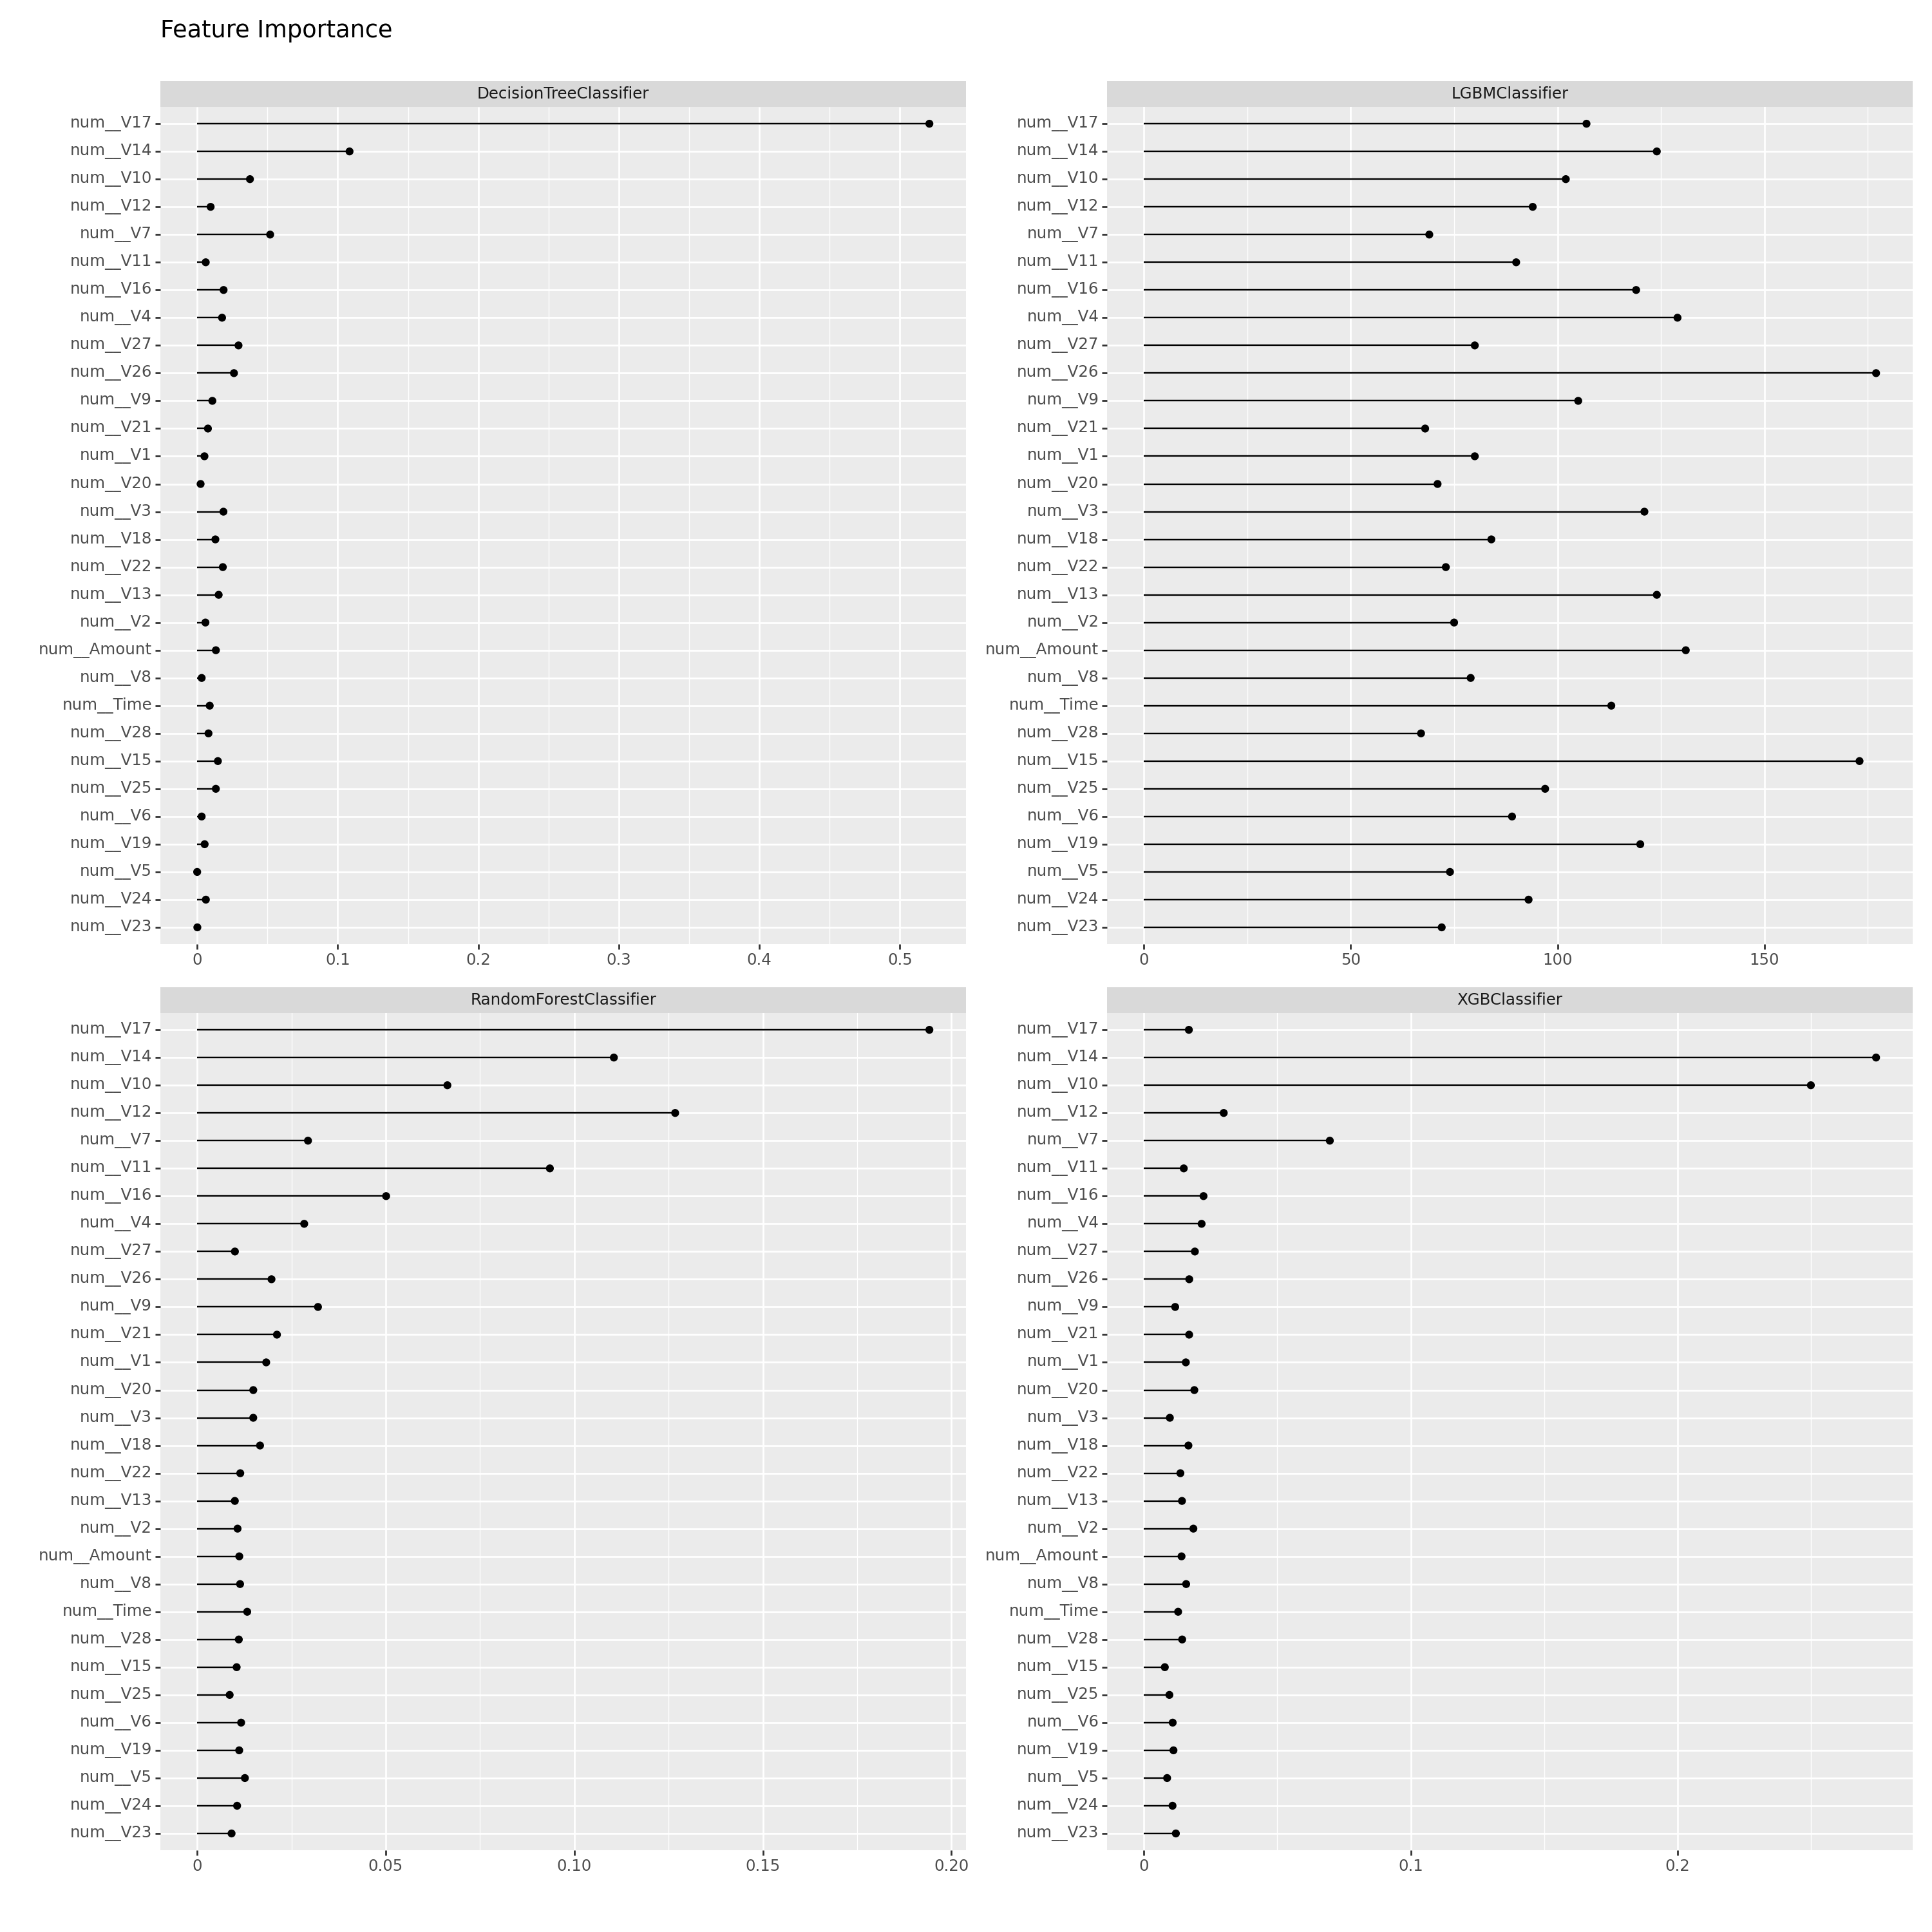

<Figure Size: (1500 x 1500)>

In [21]:
#Visualizo las feature importance

(ggplot(pd_importance,aes(x = 'reorder(predictor,importancia)', y = 'importancia')) +
  geom_segment(aes(x = 'reorder(predictor,importancia)', xend = 'predictor', y = 0, yend = 'importancia')) +
  geom_point() +
  facet_wrap('Modelo', scales= 'free')+
  coord_flip()+
  labs(x= '', y= '', title= 'Feature Importance')+
theme(
        figure_size=(15, 15) 
))


### Comentarios sobre las feature importance

- Los modelos DT, RF y XGBoost comparten la variable V14 entre las más importantes y más peso para la predicción. La V17 es particularmene importante para el algoritmo DT y RF.
- El modelo LigthGBM muestra otras variables con mayor importancia, como la V15 y la V26

### Optimizacion de hiperparámetros

In [22]:
#Creo un diccionario con los hiperparametros para cada modelo

#Logistic regression

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
lr_grid = dict(solver=solvers,penalty=penalty,C=c_values)

# #Decision Tree

max_depth =list((3, 5, 7))
criterion = ['gini', 'entropy']
dt_grid = dict(max_depth=max_depth,criterion=criterion)

# #Random Forest

n_estimators = [10, 100, 1000,10000]
max_features = ['sqrt', 'log2']
rf_grid = dict(n_estimators=n_estimators,max_features=max_features)

# #XGBOOST

learning_rate= [0.1, 0.01, 0.001]
max_depth= list((3, 5, 7))
n_estimators= [100, 200, 300]
colsample_bytree= [0.5, 0.7, 0.9]
gamma= [0, 0.1, 0.2]
xgb_grid = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, colsample_bytree =colsample_bytree,gamma=gamma)

# #LGB

class_weight = [None,'balanced']
boosting_type = ['gbdt', 'goss', 'dart']
num_leaves = [30,50,100,150] #list(range(30, 150)),
learning_rate = list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10)) #1000
lgg_grid = dict(class_weight=class_weight, boosting_type=boosting_type, num_leaves=num_leaves, learning_rate =learning_rate)



In [23]:
#Armo un data frame para guardar los resultados de la optimizacion

# #Agregar RF
columna = ['Metrica','Log','DT','XGB','LGB']
resultado = pd.DataFrame()

resultado['Modelos'] =  ['Log','DT','XGB','LGB']
resultado['mean_test_score'] = 0
resultado['std_test_score']= 0

resultado

,Modelos,mean_test_score,std_test_score
0,Log,0,0
1,DT,0,0
2,XGB,0,0
3,LGB,0,0


In [24]:
#Iteramos los modelos

from skopt import BayesSearchCV

np.random.seed(123)


#Lista de los modelos
models = [logistic,decision_tree,xgb_model,lgb_model]


#Lista de los hiperparametros
grids = [lr_grid,dt_grid,xgb_grid,lgg_grid]

#creo una lista para guardar los parametros

best_params = []

#Iteramos los modelos y el grid de parametros

for i in range(0,len(models)):
    
    #Instanciamos el optimizador
        grid_search = BayesSearchCV(
        estimator=models[i],
        search_spaces= grids[i],
        cv=3,
        n_iter=10,
        scoring='roc_auc',
        n_jobs=-1,
        refit=True,
        optimizer_kwargs={'base_estimator': 'GP'},
        random_state=123,
        verbose=1)
        
     #Ajustamos la búsqueda
        grid_fit = grid_search.fit(X_train_transf,y_train)
        
        
      #Agregamos los mejores parametros
    
        best_params.append(grid_fit.best_params_)
        
     #Guardamos los resultados   
        resultado.iloc[i,1] = pd.DataFrame(grid_fit.cv_results_) \
                        .filter(regex = '(mean_t|std_t)') \
                           .sort_values('mean_test_score', ascending = False).head(1)['mean_test_score'].values

        resultado.iloc[i,2] = pd.DataFrame(grid_fit.cv_results_) \
                        .filter(regex = '(mean_t|std_t)') \
                           .sort_values('mean_test_score', ascending = False).head(1)['std_test_score'].values
    
        print(i)
  

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\NaranjaX\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
1
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 

C:\Users\NaranjaX\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\NaranjaX\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


3


In [25]:
resultado

,Modelos,mean_test_score,std_test_score
0,Log,0.979292,0.000402
1,DT,0.883402,0.040435
2,XGB,0.973280,0.007440
3,LGB,0.968938,0.008553


#### Comentarios de la optimizacion de los Hipeparámetros

 - Se excluyó de la optimización el algoritmo Random Forest por una cuestión de recuersos computacionales.
 - Cómo métrica de optimización se eleigió el ROC_AUC
 - Si bien el modelo logístico presenta mejores métricas, por la estabilidad y agilidad se utilizará el modelo XGBoost

### Entreno el modelo final con los hiperparámetros

In [26]:
#Entreno el modelo final

#Primeramente obtengo los mejorers parámetros para el modelo XGBoost

mejores_parametros = best_params[2]
mejores_parametros

OrderedDict([('colsample_bytree', 0.9),
             ('gamma', 0.2),
             ('learning_rate', 0.1),
             ('max_depth', 3),
             ('n_estimators', 200)])

In [27]:
# mejores parametros
#Creo el diccionario para no volver a correr la optimizacion

mejores_parametros = {'colsample_bytree': 0.9,
             'gamma': 0.2,
             'learning_rate': 0.1,
             'max_depth': 3,
             'n_estimators': 200}

mejores_parametros

{'colsample_bytree': 0.9,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200}

In [28]:
# Intancio el modelo con los hiperparametros 

final_xgb_model = xgb.XGBClassifier(random_state=123, verbose=-100, **mejores_parametros)

In [29]:
#Ajusto el modelo y obtengo las métricas

ultimate_test_xgb = run_exploration(final_xgb_model,X_train= X_train_transf,X_test= X_test_transf,y_train=y_train,y_test=y_test,test_impac= X_test)

C:\Users\NaranjaX\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.



XGBClassifier
--------------   TRAIN   -------------------
--------------------------------------------
Accuracy: 1.0
Recall: 0.866
ROC_AUC: 0.933
Precisión: 0.986
f1 score: 0.922
KS: 0.988
--------------------------------------------
XGBClassifier
--------------   TEST    -------------------
--------------------------------------------
Accuracy: 1.0
Recall: 0.803
ROC_AUC: 0.902
Precisión: 0.929
f1 score: 0.861
KS: 0.916
--------------------------------------------


### Metricas de impacto del modelo

Hasta ahora se midió la performance del modelo desde el punto de vista de ¿Qué tan bien clasifica nuestro modelo? ¿En cuanto de aleja de los valores reales?. Ahora toca medir que *impacto tiene nuestro modelo en el negocio*, ¿cuánto ahorro generaremos en contracargos?, ¿En cuánto afectaremos al negocio para obtener ese ahorro?.
Para este trabajo uso una librería creada ad-hoc que se llama **evaluate** que tiene una función que lleva el mismo nombre, es decir evaluate. Toma como parámetros un dataframe -en este caso el conjunto de test-, un umbral de probabilidad y la identificación del target. Como resultado, nos devuelve una serie de métricas relacionadas con el impacto sobre el negocio como: % de rechazo, el % de ahorro en contracargos sobre TPV, el TPV total de contracargos, el revenue, etc.

In [30]:
from evaluate import *

In [31]:
impacto = evaluate(ultimate_test_xgb[4],0.5,'target')

------IMPACTO DEL MODELO--------
------------RECALL-------------
80.34
-------FALSOS POSITIVOS--------
0.01
-----------PRECISION-----------
75.66
--------------KS---------------
92.0
-------TASA RECHAZO TOTAL------
0.055
-----TPV FRAUDE PREV. TOTAL----
74.06
Ganancia Verdaderos Positivos 16.378,62 
Costo Falsos Positivos 85,23 
Costo Falsos Negativos: 5.735,80 
Ganancia Verdaderos Negativos: 493.400,08
Balance: 10.557,59
Razon Costos/Ganancia: 0,36


C:\Users\NaranjaX\Documents\ScriptsML\python\FraudClassification\evaluate.py:34: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.


### Comentarios sobre el impacto

 - En este caso tomamos como umbral de clasificación 0.5, es decir el valor por defecto en un modelo de clasificación binario.
 - Si nos concentramos en las mpetricas de impacto este modelo permite:
     - Prevenir el 74% del TPV fraudulento con una tasa de rechazo de 0,05%, lo que son métricas muy buenas de impacto.
     - Asimismo, nos genera un ahorro en contracargos de *16.378 pesos*, con solo *85 pesos* de falsos positivos y *5.735 pesos* de falsos negativos, es decir contracargos mal clasificados como genuinos. Eso da una razón de *0.36 pesos* invertidos para prevenir *1 pesos* de contracargos.
 - Vale mencionar que en la fórmula de balance cada contracargo tiene un costo del 100%, al igual que los falsos negativos, es decir los contracargos mal clasificados como genuinos. En cambio, los falsos positivos tienen el impacto de la comisión pérdida, en este ejemplo *0.6%*.

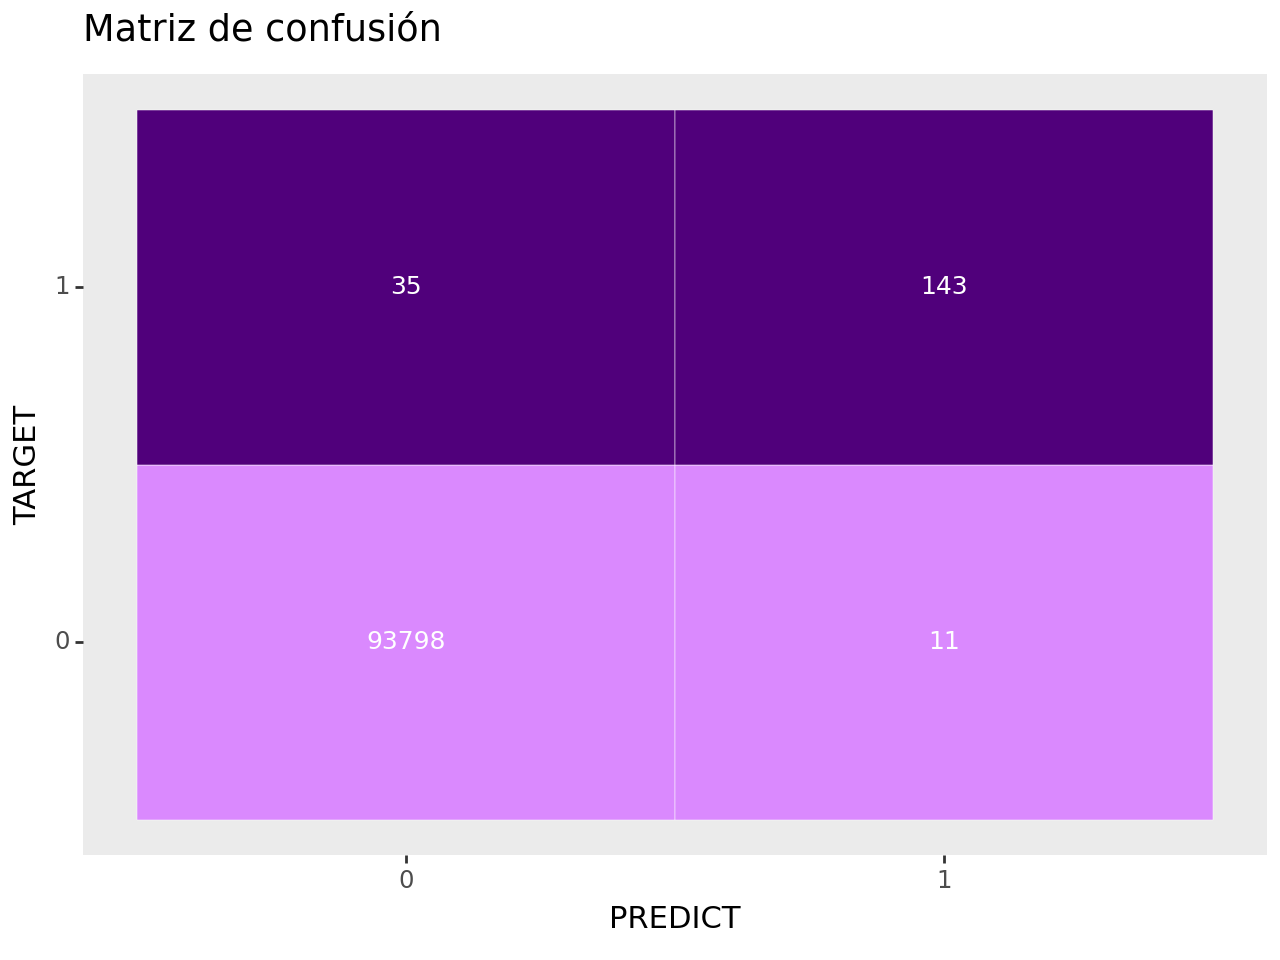

<Figure Size: (640 x 480)>

In [32]:
# Veamos la matriz de confusión

impacto[1]

## Analizamos la distribución del score

In [33]:
#Calculo los veintiles

probabilidades = ultimate_test_xgb[4].copy()

cuantiles,threshold =pd.qcut(probabilidades['pred'], q=20, labels=False, duplicates='drop',retbins=True)


probabilidades['veintil']  = cuantiles

#Agrupo el target por veintiles
prob_agrup = probabilidades.groupby('veintil').agg(
    pob_0=('target', lambda x: (x == 0).sum()),
    pob_1=('target', lambda x: (x == 1).sum())
)

#Obtengo el % acumulado
prob_agrup['cum_sum_prop_0'] = prob_agrup['pob_0'].cumsum() * 100 /prob_agrup['pob_0'].sum()
prob_agrup['cum_sum_prop_1'] = prob_agrup['pob_1'].cumsum() * 100 /prob_agrup['pob_1'].sum()

prob_agrup['score'] = threshold[:-1]
prob_agrup


,pob_0,pob_1,cum_sum_prop_0,cum_sum_prop_1,score
veintil,,,,,
0,4700,0,5.010180,0.000000,5.586606e-07
1,4699,0,10.019295,0.000000,5.873739e-06
2,4699,0,15.028409,0.000000,8.945794e-06
3,4700,0,20.038589,0.000000,1.171355e-05
4,4699,0,25.047703,0.000000,1.462814e-05
5,4699,0,30.056818,0.000000,1.777872e-05
6,4700,0,35.066998,0.000000,2.113284e-05
7,4698,1,40.075046,0.561798,2.492794e-05
8,4699,0,45.084160,0.561798,2.942925e-05


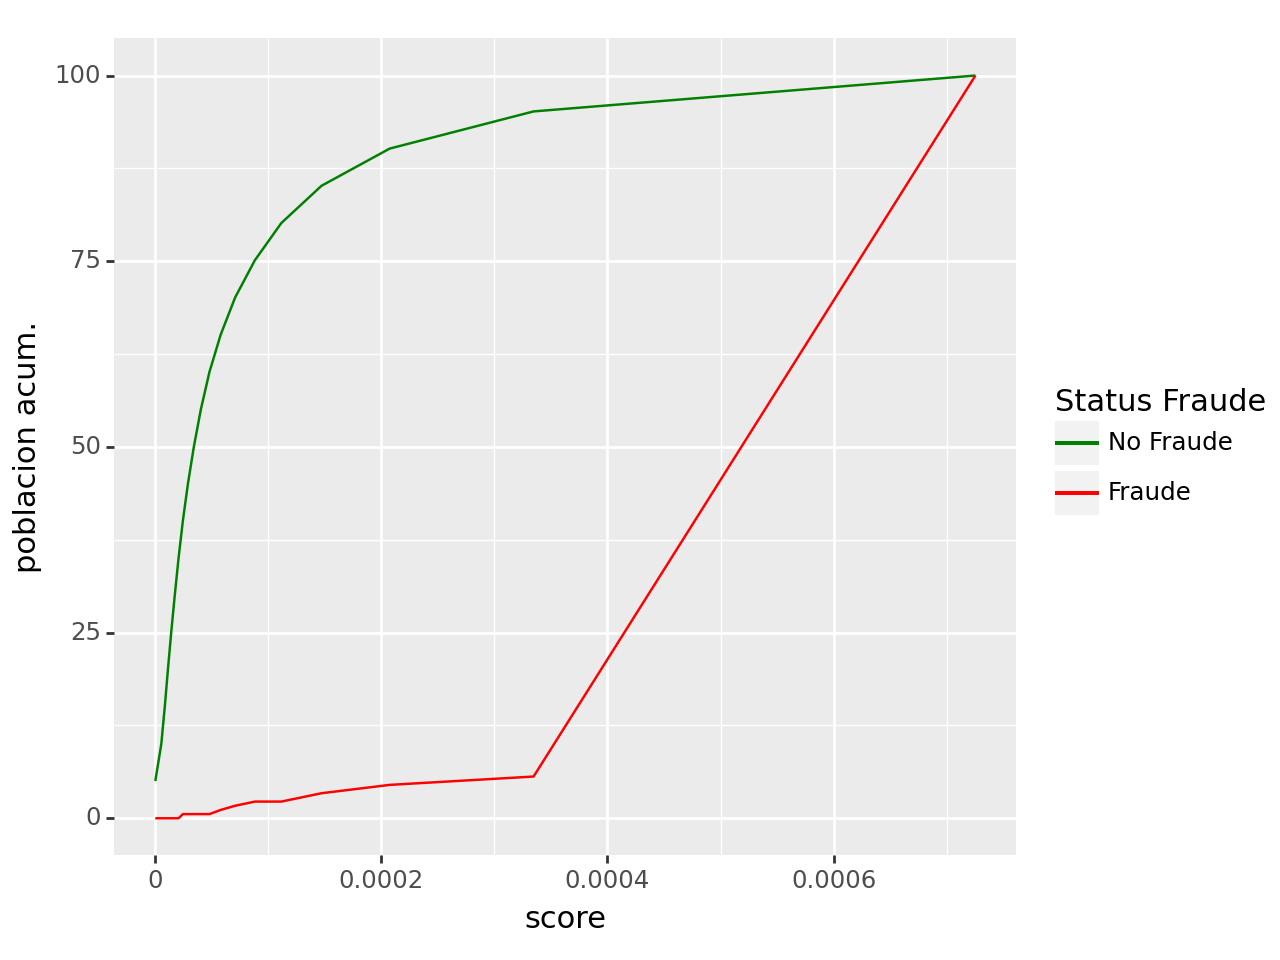

<Figure Size: (640 x 480)>

In [34]:
#Lo veo en un gráfico

(ggplot(prob_agrup, aes(x= "score"))+
geom_line(aes(y= "cum_sum_prop_0",color= "'green'"))+
geom_line(aes(y= "cum_sum_prop_1",color= "'red'") )+
labs(y= "poblacion acum.")+
scale_color_identity(guide='legend',name= "Status Fraude",
                    breaks=['green','red'],
                        labels=['No Fraude','Fraude']))


Con la misma función evaluate podemos analizar las métricas de impacto utilizando por ejemplo el último veintil del score. Si bien en nuestro caso no es necesario, dado la performance obtenida, podemos probar y ver que sucede.

In [35]:
impacto_2 = evaluate(ultimate_test_xgb[4],0.00007250821,'target')

------IMPACTO DEL MODELO--------
------------RECALL-------------
98.88
-------FALSOS POSITIVOS--------
34.4
-----------PRECISION-----------
0.54
--------------KS---------------
92.0
-------TASA RECHAZO TOTAL------
11.508
-----TPV FRAUDE PREV. TOTAL----
98.68
Ganancia Verdaderos Positivos 21.822,72 
Costo Falsos Positivos 255.956,58 
Costo Falsos Negativos: 291,70 
Ganancia Verdaderos Negativos: 237.528,73
Balance: -234.425,56
Razon Costos/Ganancia: 11,74


C:\Users\NaranjaX\Documents\ScriptsML\python\FraudClassification\evaluate.py:34: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.


En este caso el incremento en los falsos positivos genera un balance negativo del revenue, por lo que no sería necesario implementar esta estrategia.

## Interpretabilidad de los modelos

Un aspecto siempre complejo de los modelos de machine learning es la dificultad de interpretación, ya que funcionan como *'cajas negras'* -dónde sabemos los inputs y los outputs pero no lo que sucede en su interior.

En este apartado veremos una técnica que nos va a permitir facilitar esa interpretabilidad de los modelos, llamada SHAP del ingles (SHapley Additive exPlanations).

#### SHAP

In [36]:
#importamos la librería

import shap

In [37]:
#Tomamos una muestra del conjunto de test para crear el gráfico SHAP

muestra = X_test_transf.sample(frac= 0.3, random_state= 123)

In [38]:
#Creamos un objeto explainer
explainer = shap.TreeExplainer(final_xgb_model,muestra)

In [39]:
shap_values = explainer(muestra)

 99%|===================| 27894/28196 [01:01<00:00]        

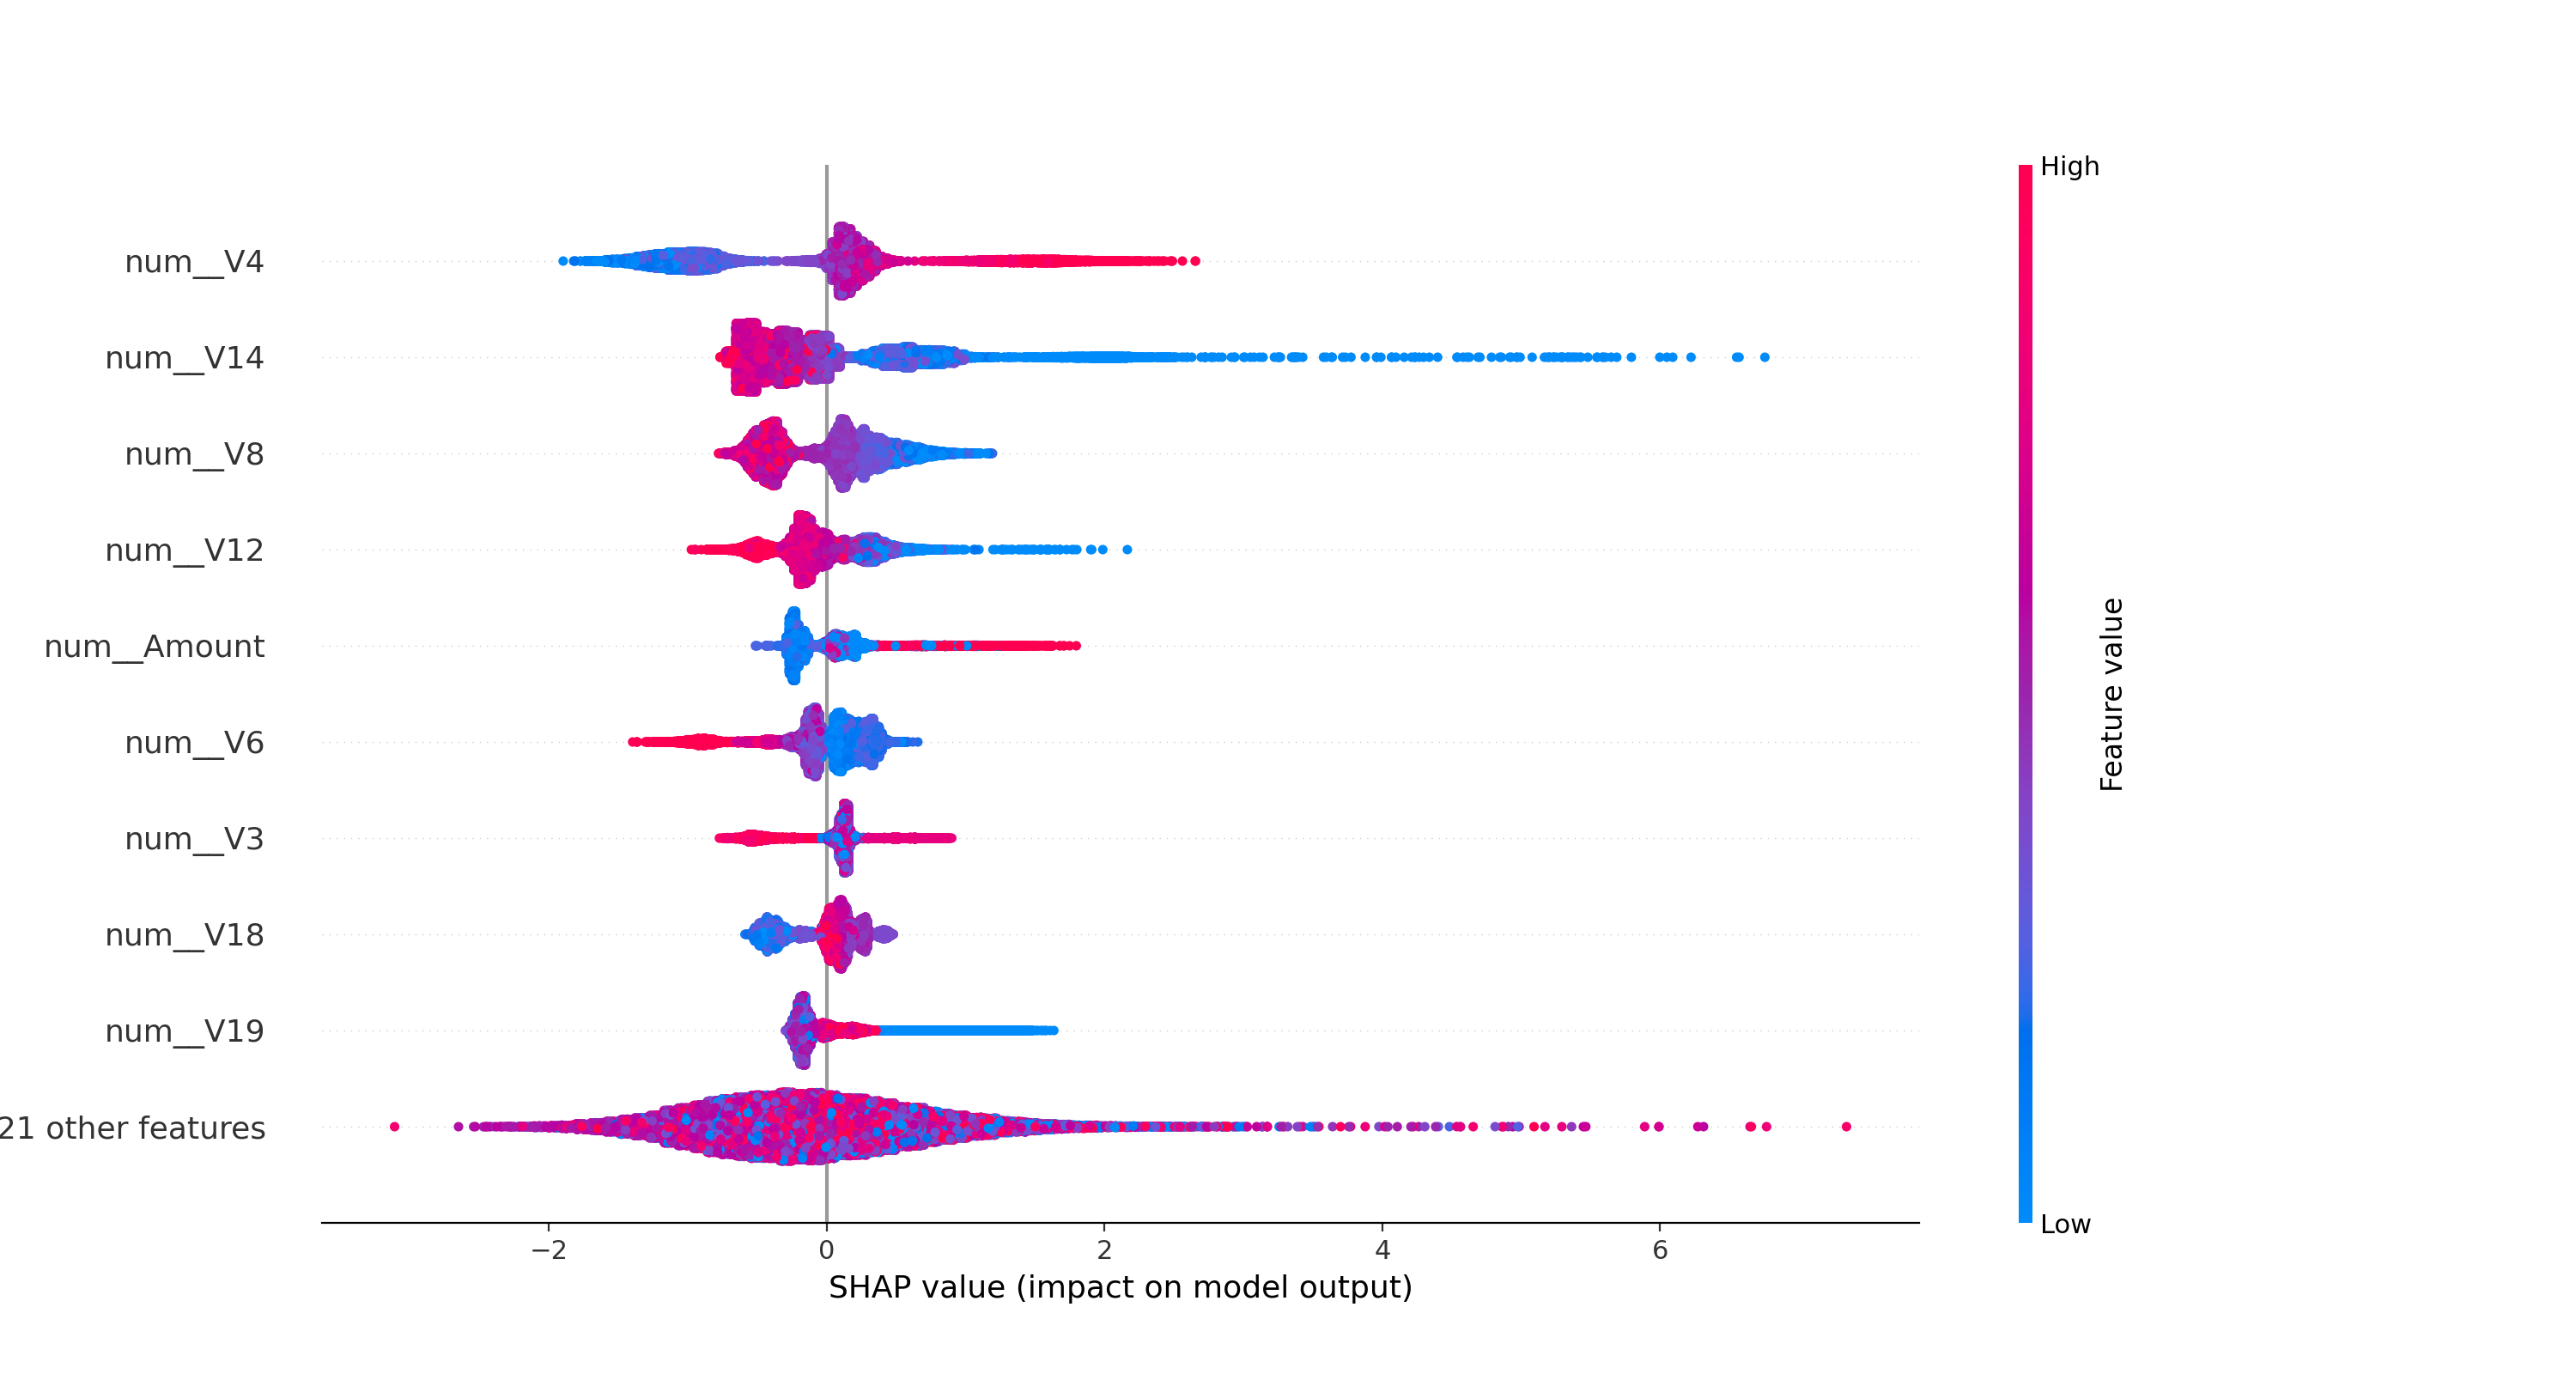

In [40]:
shap.plots.beeswarm(shap_values, plot_size=[15,8])

### Comentarios sobre el gráfico SHAP

Este gráfico ordena las feature por su impacto en la predicción, es decir en la prediccón la variable V4 tiene más impacto, le siguen V14, V8,V12 y luego Amount. Pero además este grafico nos permite describir la dirección de la influencia de la feature. Es decir, los valores altos de V4 tiene impacto positivo sobre las predicciones, en cambio para V14 los valores bajos tienen impacto positivo sobre las predicciones. Los valores altos de V6 impactan de forma negativa sobre las predicciones.